## Importar bibliotecas

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
import pickle

plt.style.use('ggplot')
%matplotlib inline


## Carregar dados

In [ ]:

def load_data(file_path):
    """
    Carrega dados do arquivo CSV.
    """
    df = pd.read_csv(file_path)
    df = df.drop(columns=['id'])
    return df

data_path = '../data/isbsg_sample_dataset.csv'
df = load_data(data_path)

df.head()


,FunctionalSize,ValueAdjustmentFactor,ProjectElapsedTime,DevelopmentType,BusinessAreaType,ClientServer,DevelopmentPlatform,LanguageType,FirstOS,MaxTeamSize,NormalisedWorkEffortLevel1,PrimaryProgrammingLanguage,ProjectYear,DevelopmentManagementTechnique
0,3,1.09,16.43,Enhancement,?,Yes,?,?,?,?,28,PHP,2011,Waterfall
1,620,?,7.93,New_Development,?,?,MF,3GL,Unix,?,18160,.NET,2015,RAD
2,730,1.14,6.51,Enhancement,?,?,MF,3GL,Unix,?,20975,Ruby,2021,Agile
3,114,1.18,7.47,Enhancement,?,?,?,3GL,?,?,7290,C#,2001,Waterfall
4,460,1,4.05,Enhancement,?,?,?,?,?,5,2253,C#,2014,RAD


## Exploração básica do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   FunctionalSize                  952 non-null    int64  
 1   ValueAdjustmentFactor           952 non-null    object 
 2   ProjectElapsedTime              952 non-null    float64
 3   DevelopmentType                 952 non-null    object 
 4   BusinessAreaType                952 non-null    object 
 5   ClientServer                    952 non-null    object 
 6   DevelopmentPlatform             952 non-null    object 
 7   LanguageType                    952 non-null    object 
 8   FirstOS                         952 non-null    object 
 9   MaxTeamSize                     952 non-null    object 
 10  NormalisedWorkEffortLevel1      952 non-null    int64  
 11  PrimaryProgrammingLanguage      952 non-null    object 
 12  ProjectYear                     952 

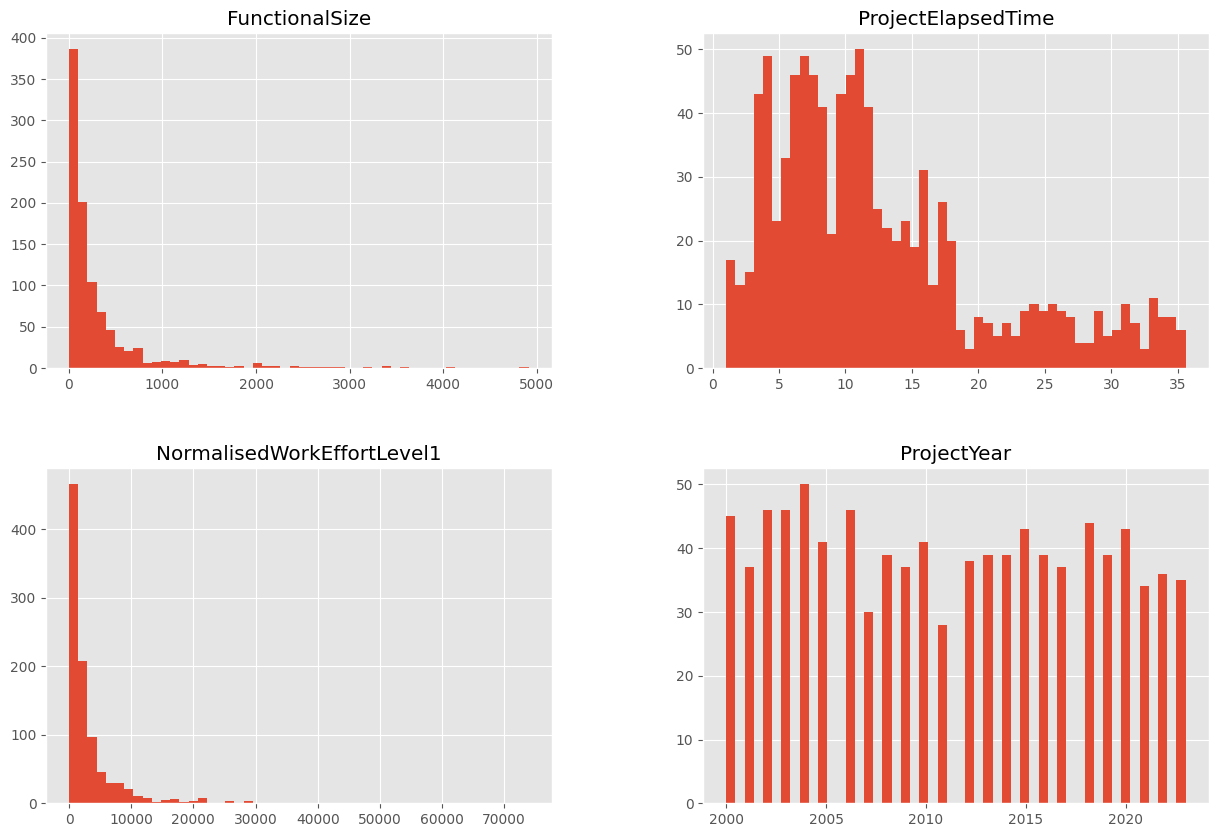

In [ ]:

df.info()
df.describe()

df.hist(bins=50, figsize=(15,10))
plt.show()


## Pré processamento

In [ ]:
def clean_data(df):
    """ 
    Limpeza básica dos dados, substituindo valores ausentes pela mediana.
    Ignora o valor -1 ao calcular a mediana e substitui -1 pela mediana nas colunas aplicáveis.
    """
    df = df.replace("?", -1)

    columns_to_replace_median = [
        col for col in df.columns 
        if col not in ['ProjectYear', 'NormalisedWorkEffortLevel1'] and pd.api.types.is_numeric_dtype(df[col])
    ]

    df[columns_to_replace_median] = df[columns_to_replace_median].replace(-1, pd.NA)

    for col in columns_to_replace_median:
        if df[col].isnull().any():
            median = df[col].median(skipna=True)  
            df[col].fillna(median, inplace=True)  

    df[['ProjectYear', 'NormalisedWorkEffortLevel1']] = df[['ProjectYear', 'NormalisedWorkEffortLevel1']].replace(pd.NA, -1)

    return df

df = clean_data(df)
df.head()


,FunctionalSize,ValueAdjustmentFactor,ProjectElapsedTime,DevelopmentType,BusinessAreaType,ClientServer,DevelopmentPlatform,LanguageType,FirstOS,MaxTeamSize,NormalisedWorkEffortLevel1,PrimaryProgrammingLanguage,ProjectYear,DevelopmentManagementTechnique
0,3,1.09,16.43,Enhancement,-1,Yes,-1,-1,-1,-1,28,PHP,2011,Waterfall
1,620,-1,7.93,New_Development,-1,-1,MF,3GL,Unix,-1,18160,.NET,2015,RAD
2,730,1.14,6.51,Enhancement,-1,-1,MF,3GL,Unix,-1,20975,Ruby,2021,Agile
3,114,1.18,7.47,Enhancement,-1,-1,-1,3GL,-1,-1,7290,C#,2001,Waterfall
4,460,1,4.05,Enhancement,-1,-1,-1,-1,-1,5,2253,C#,2014,RAD


## Encode dos dados

In [ ]:
def encode_categorical(df):
    """ Codificação one-hot para variáveis categóricas """
    df = pd.get_dummies(df, drop_first=True) 
    return df

df['performance_ratio'] = (df['FunctionalSize'] / df['ProjectElapsedTime']) * df['NormalisedWorkEffortLevel1']
performance_threshold = df['performance_ratio'].quantile(0.75)
df['performance'] = np.where(df['performance_ratio'] >= performance_threshold, 1, 0) 

df = encode_categorical(df)

## Exploração do dataset após limpeza e codificação

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Columns: 131 entries, FunctionalSize to DevelopmentManagementTechnique_Waterfall
dtypes: bool(125), float64(2), int64(4)
memory usage: 161.0 KB


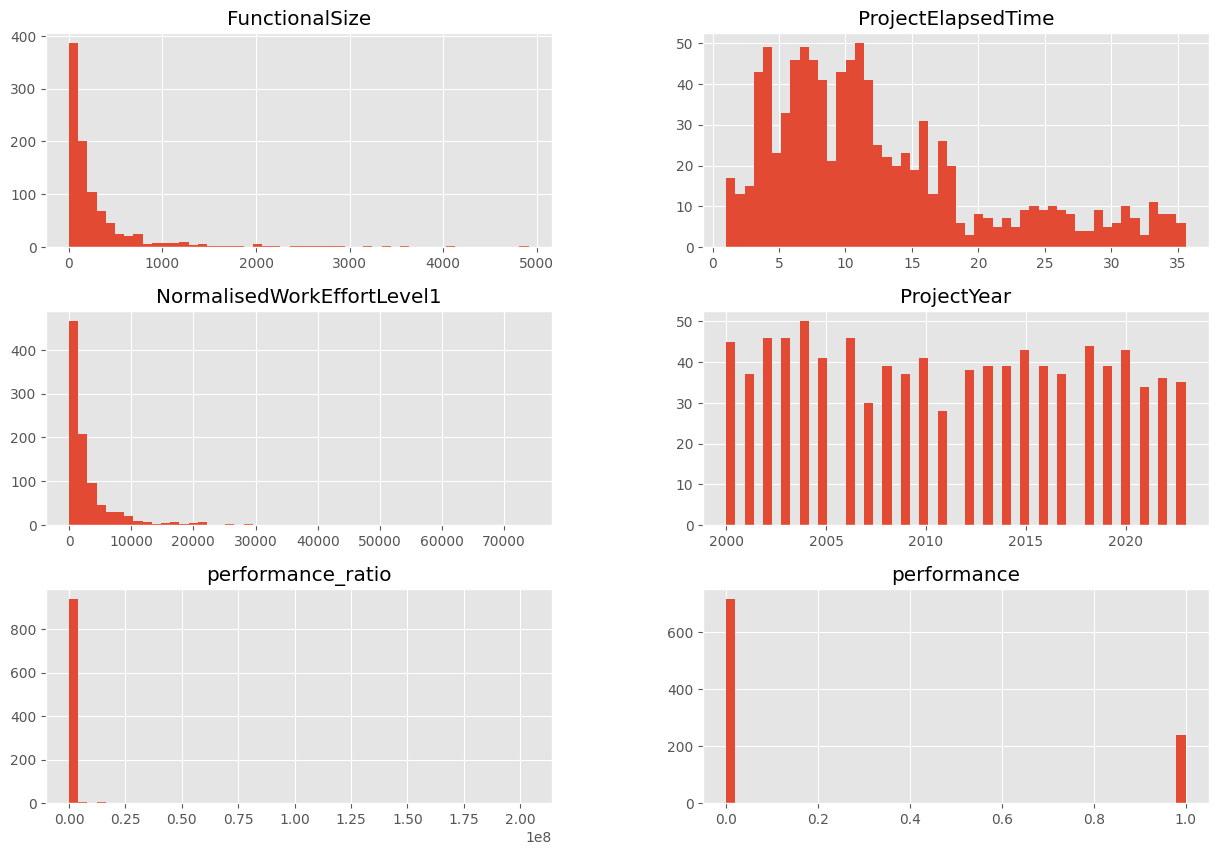

In [ ]:
df.info()
df.describe()

df.hist(bins=50, figsize=(15,10))
plt.show()

## Preparar os dados para classificação


In [ ]:
X = df.drop(columns=['ProjectElapsedTime', 'performance_ratio', 'performance']) 
y = df['performance'] 

## Divisão dos dados para treino

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)


(761, 191)

## Treinamento do modelo

In [ ]:

def train_model(X_train, y_train):
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model

model = train_model(X_train, y_train)


## Avaliação do modelo

In [ ]:

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
    print("Acurácia:", accuracy_score(y_test, y_pred))
    importance = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)
    print("Importância das Variáveis:\n", importance_df.head(10))
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X)
    df['Cluster'] = clusters
    cluster_performance = df.groupby('Cluster')['performance'].mean()
    print("Desempenho médio por cluster:\n", cluster_performance)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    return mae, mse, rmse

evaluate_model(model, X_test, y_test)


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       139
           1       0.90      0.90      0.90        52

    accuracy                           0.95       191
   macro avg       0.93      0.93      0.93       191
weighted avg       0.95      0.95      0.95       191

Acurácia: 0.9476439790575916
Importância das Variáveis:
                                       Feature  Importance
0                              FunctionalSize    0.630865
1                  NormalisedWorkEffortLevel1    0.275293
127  DevelopmentManagementTechnique_Waterfall    0.034206
14                 ValueAdjustmentFactor_0.88    0.005665
78                             MaxTeamSize_15    0.005295
41                 ValueAdjustmentFactor_1.15    0.004619
59                           ClientServer_Yes    0.003767
46                  ValueAdjustmentFactor_1.2    0.003444
73                             MaxTeamSize_10    0.003114
119    

(np.float64(0.05235602094240838),
 np.float64(0.05235602094240838),
 np.float64(0.22881438097813778))

In [27]:

# Salvamento do modelo treinado
model_path = './artifacts/models/random_forest_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Modelo salvo em: {model_path}")


FileNotFoundError: [Errno 2] No such file or directory: './artifacts/models/random_forest_model.pkl'